# Flow Through Trees

The simulation of a turbulent flow over an arrangement of trees is used as validation for the points cloud implementation with immersed boundary method. The points cloud is distributed in an Cartesian arrangement with a distancing between points of 1 node of most refined lvl. 
The points area is the squared distance between points at lvl 0.
For comparison, the results of [Qi and Ishihara, 2018](https://doi.org/10.1016/j.jweia.2018.04.007) and [Kang et al., 2020](https://doi.org/10.1016/j.scs.2020.102086) were used.

It consists of a 2 x 74 x 6(m) tree arrangement positioned at 1m height after an atmospheric flow.
The drag coefficient is estimated 1.6 and LAD=$1.16m^{-1}$ hence the `force_factor` will be 1.856 for $\Delta x$=1m (and 0.468 for $\Delta x$=0.25m), as illustrated below:

![localimage](images/schematic.svg)

The numerical setup goal is to correctly capture both velocity and turbulent kinetic energy changes caused by the tree arrangement. The domain setup is shown below:

![localimage](images/domain-config.jpeg)

In [1]:
from nassu.cfg.model import ConfigScheme

filename = "./tests/validation/cases/10_flow_through_trees.nassu.yaml"

sim_cfgs = ConfigScheme.sim_cfgs_from_file_dct(filename)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

H_num = 7
scale = 1

Load experimental data:

In [3]:
base_path = Path("./tests/validation/comparison/Tree_effect/qi2018/exp")
positions = ["1H", "2H", "3H", "4H", "5H"]

df_exp = []

vel = pd.read_csv(base_path / "velocity/pitot.csv")
kin = pd.read_csv(base_path / "kinetic_energy/pitot.csv")
df_csv = pd.concat([vel, kin], axis=1, join="inner")
df_exp.append(df_csv)

for pos in positions:
    vel = pd.read_csv(base_path / f"velocity/{pos}.csv")
    kin = pd.read_csv(base_path / f"kinetic_energy/{pos}.csv")
    df_csv = pd.concat([vel, kin], axis=1, join="inner")
    df_exp.append(df_csv)

In [4]:
base_path = Path("./tests/validation/comparison/Tree_effect/qi2018/num")
positions = ["1H", "2H", "3H", "4H", "5H"]

df_num2 = []

vel = pd.read_csv(base_path / "velocity/pitot.csv")
kin = pd.read_csv(base_path / "kinetic_energy/pitot.csv")
df_csv = pd.concat([vel, kin], axis=1, join="inner")
df_num2.append(df_csv)

for pos in positions:
    vel = pd.read_csv(base_path / f"velocity/{pos}.csv")
    kin = pd.read_csv(base_path / f"kinetic_energy/{pos}.csv")
    df_csv = pd.concat([vel, kin], axis=1, join="inner")
    df_num2.append(df_csv)

## Results

In [5]:
sim_cfg = sim_cfgs["flowThroughTrees", 0]

point_ref = sim_cfg.output.series["velocities"].points["velocity_probe"]
df_ref = point_ref.read_full_data("ux")

df_ref = df_ref[df_ref["time_step"] > 10000]

df_point = df_ref

ux_avg = df_ref.mean()
ux_rms = df_ref.std()
Iu = ux_rms / ux_avg

u_ref = ux_avg[1]
u_ref

/tmp/ipykernel_3583828/3034823928.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u_ref = ux_avg[1]


0.025674967095255852

In [6]:
def line_stats(position: str, u_ref) -> pd.DataFrame:
    line_ref = sim_cfg.output.series["velocities"].lines[f"{position}"]
    df_ux = line_ref.read_full_data("ux")
    df_uy = line_ref.read_full_data("uy")
    df_uz = line_ref.read_full_data("uz")

    df_ux = df_ux[df_ux["time_step"] > 10000]
    df_uy = df_uy[df_uy["time_step"] > 10000]
    df_uz = df_uz[df_uz["time_step"] > 10000]

    ux_avg = (df_ux.mean()) / u_ref
    ux_rms = (df_ux.std()) ** 2

    uy_rms = (df_uy.std()) ** 2
    uz_rms = (df_uz.std()) ** 2

    k = (ux_rms + uy_rms + uz_rms) / (2 * u_ref**2)

    df = pd.DataFrame({"ux_avg": ux_avg, "k": k})
    df = df.drop(df.index[0])
    df["pos"] = np.linspace(0, (2 * H_num) / H_num, num=len(df), endpoint=True)
    return df

In [7]:
df_num = []
df_csv = line_stats("velocity_profile", u_ref)
df_num.append(df_csv)

for pos in positions:
    df_csv = line_stats(f"pos_{pos}", u_ref)
    df_num.append(df_csv)

In [8]:
def plot_curves(position: str, df_num, df_num2, df_exp):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(12, 5)
    fig.suptitle(f"{position}")

    ax[0].plot(df_num["ux_avg"], df_num["pos"], "-b", label="AeroSim")
    ax[0].plot(df_num2["u"], df_num2["z"], "--r", label="Qi and Ishihara (2018)")
    ax[0].plot(df_exp["u"], df_exp["z"], marker="o", linestyle="None", color="g", label="Exp")
    ax[0].set_ylabel("$z/H$")
    ax[0].set_xlabel("$u/u_{H}$")
    ax[0].set_xlim(0, 2.0)
    ax[0].set_ylim(0, 1.2)
    ax[0].legend(loc="best")
    ax[0].grid()

    ax[1].plot(df_num["k"], df_num["pos"], "-b", label="AeroSim")
    ax[1].plot(df_num2["k"], df_num2["h"], "--r", label="Qi and Ishihara (2018)")
    ax[1].plot(df_exp["k"], df_exp["h"], marker="o", linestyle="None", color="g", label="Exp")
    ax[1].set_ylabel("$z/H$")
    ax[1].set_xlabel("TKE/$u_{H}^{2}$")
    ax[1].set_xlim(0, 0.2)
    ax[1].set_ylim(0, 1.2)
    ax[1].legend(loc="best")
    ax[1].grid()

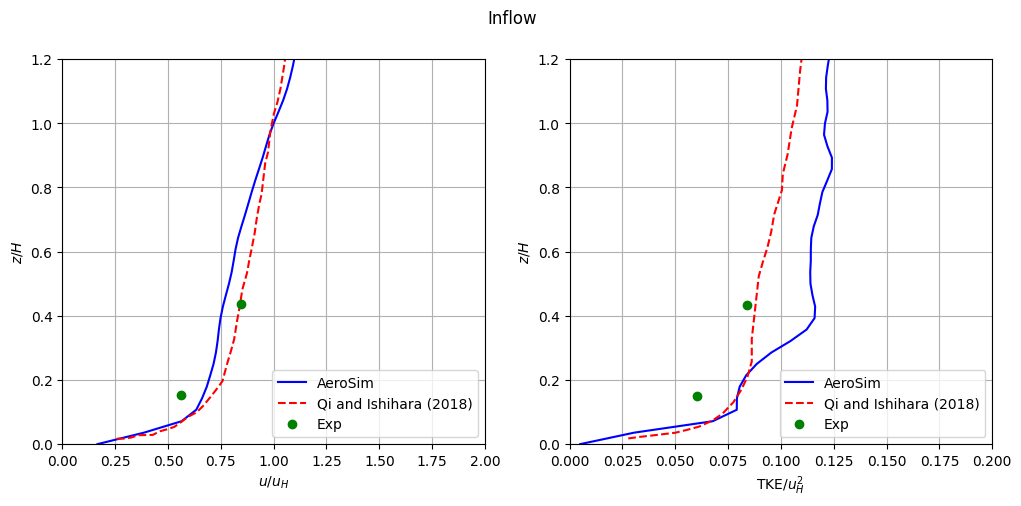

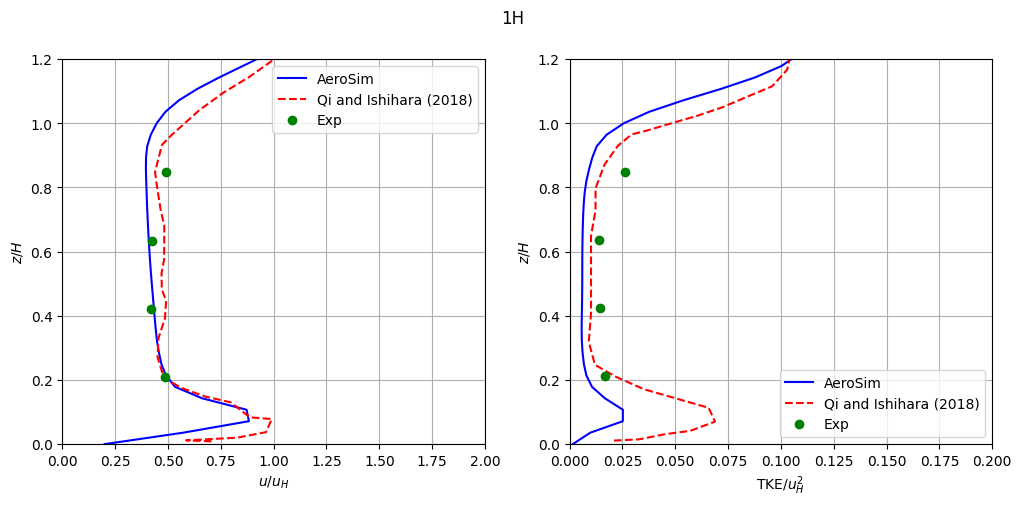

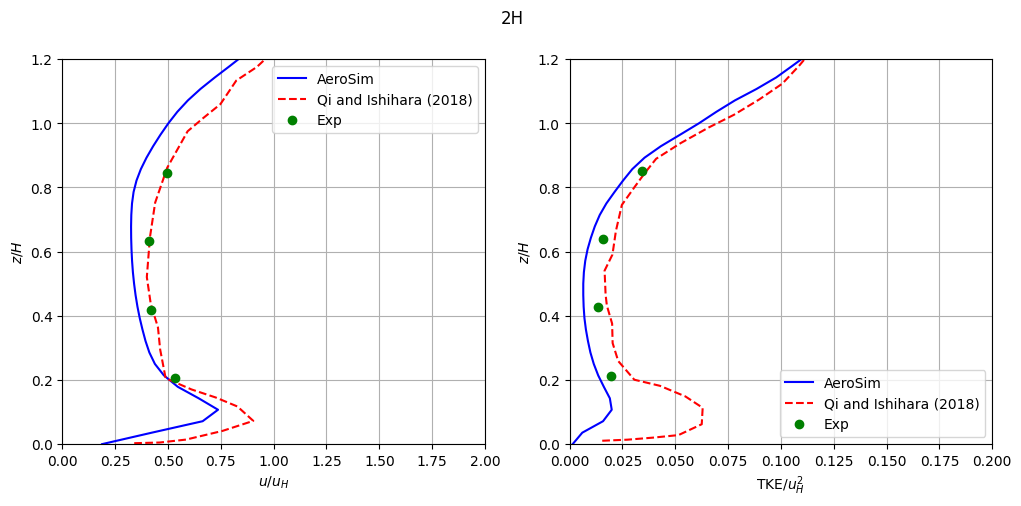

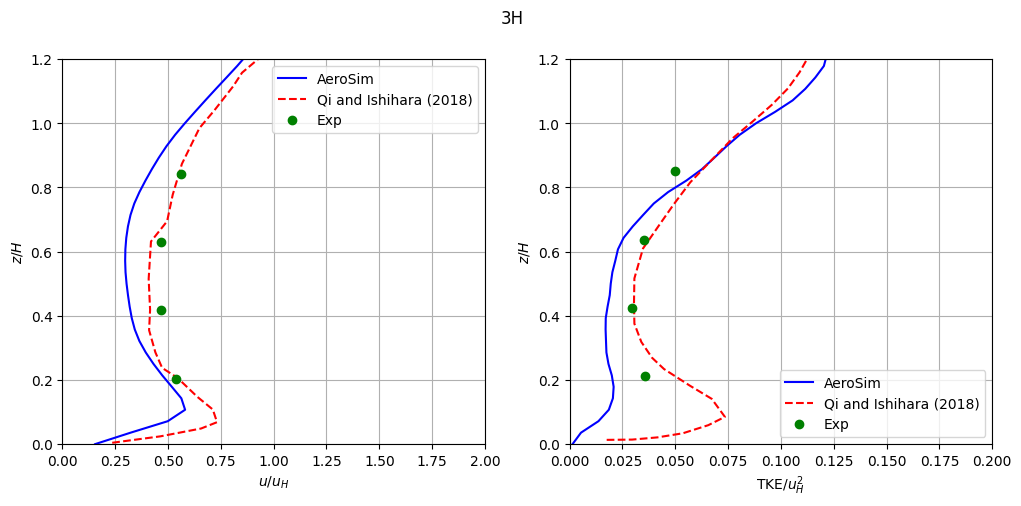

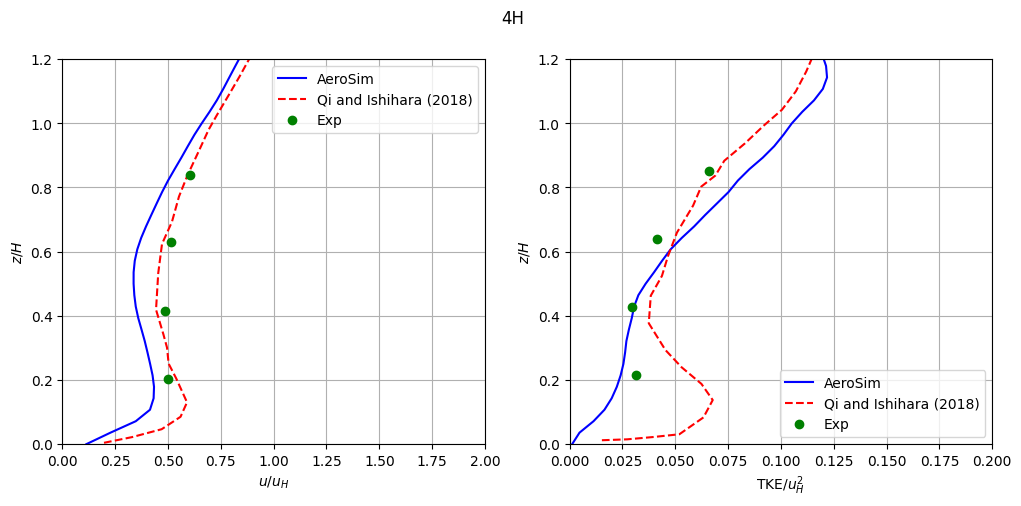

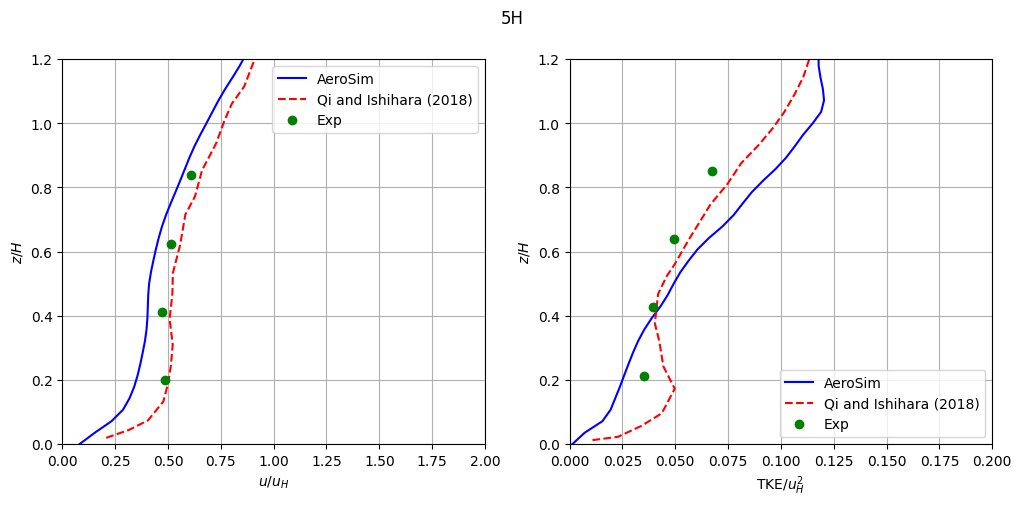

In [9]:
## Inflow plot
plot_curves("Inflow", df_num[0], df_num2[0], df_exp[0])

## Post obstacles plots
for i, pos in enumerate(positions):
    plot_curves(pos, df_num[i + 1], df_num2[i + 1], df_exp[i + 1])

It can be seen a satisfactory match between inflow and experimental data despite the coarse resolution applied on the validation case.
The qualitative aspects of the flow profile after the tree arrangement are well reproduced and quantitative aspects also have a decent representation.
The difference compared to Qi and Ishihara results might be due our resolution of 0.25m against their 0.025m close to the ground.

## Version

In [10]:
sim_cfg = next(iter(sim_cfgs.values()))
sim_info = sim_cfg.output.read_info()

nassu_commit = sim_info["commit"]
nassu_version = sim_info["version"]
print("Version:", nassu_version)
print("Commit hash:", nassu_commit)

Version: 1.6.17
Commit hash: cab6b7ad2a955ba7656e05b10c2cee0c8f0fdad4


## Configuration

In [11]:
from IPython.display import Code

Code(filename=filename)

variables:
  domain:
    scale: !math 1/1
    plane_height: 4.0
    body_pos: 200
    H_ref:
    pos_025H: !math ${domain.body_pos} + 0.25*${var.H_num}
    pos_05H: !math ${domain.body_pos} + 0.5*${var.H_num}
    pos_1H: !math ${domain.body_pos} + 1.0*${var.H_num}
    pos_2H: !math ${domain.body_pos} + 2.0*${var.H_num}
    pos_3H: !math ${domain.body_pos} + 3.0*${var.H_num}
    pos_4H: !math ${domain.body_pos} + 4.0*${var.H_num}
    pos_5H: !math ${domain.body_pos} + 5.0*${var.H_num}
  var:
    H_num: !math 7*${domain.scale}

simulations:
  - name: flowThroughTrees
    save_path: ./tests/validation/results/10_flow_through_trees

    n_steps: 40000

    report:
      frequency: 500

    domain:
      domain_size:
        x: 600
        y: 144
        z: 64
      block_size: 8
      point_clouds:
        tree:
          IBM:
            run: True
            cfg_use: tree_cfg
            order: 1
            interval_run:
              end_step: 0
              start_step: 0
          csv_path: fixture/point_clouds/cube_2x74x6.csv
          transformation:
            scale: !math ["${domain.scale}", "${domain.scale}", "${domain.scale}"]
            translation: !math ["${domain.body_pos}", 72, "1.0+${domain.plane_height}"]
      bodies:
        full_plane:
          IBM:
            run: True
            cfg_use: category_II
            order: 0
          lnas_path: fixture/lnas/wind_tunnel/full_plane.lnas
          small_triangles: add
          transformation:
            translation: !math [0, 0, "${domain.plane_height}"]
        plates_obstacles:
          IBM:
            order: 1
          lnas_path: fixture/lnas/wind_tunnel/category_II/plates_Nx160Ny70_6x2_spacing16x32_offset19y.lnas
          volumes_limits:
            body_transformed:
              - start: !math [10, 20, 0]
                end: !math [120, 124, 64]
          small_triangles: add
          transformation:
            translation: !math [0, 1, "${domain.plane_height}"]
            scale: !math [4.0, 4.0, "2*32.0*${domain.scale}"] #2m

      refinement:
        static:
          default:
            volumes_refine:
              # - start: [0, 56, 2]
              #   end: [256, 88, 12]
              #   lvl: 3
              #   is_abs: true
              - start: [0, 34, 0]
                end: [288, 110, 24]
                lvl: 2
                is_abs: true
              - start: [0, 0, 0]
                end: [352, 144, 40]
                lvl: 1
                is_abs: true

    data:
      divergence: { frequency: 10 }
      monitors:
        fields:
          rho_max:
            macrs: [rho]
            stats: [min, max]
            interval: { start_step: 500, end_step: 10000, frequency: 50 }
      instantaneous:
        full_domain:
          { interval: { frequency: 10000 }, macrs: [rho, u, omega_LES, f_IBM] }
      statistics:
        interval: { frequency: 10, start_step: 10000 }
        macrs_1st_order: [rho, u]
        macrs_2nd_order: [u]
        exports:
          full_domain: { interval: { frequency: 10000 } }
      probes:
        historic_series:
          velocities:
            macrs: ["u"]
            interval: { frequency: 10, lvl: 0 }
            points:
              velocity_probe:
                pos:
                  !math [
                    "${domain.body_pos}-50*${domain.scale}",
                    72,
                    "${domain.plane_height} + 7*${domain.scale}",
                  ]
            lines:
              inlet_profile:
                dist: 0.25
                start_pos: !math [0, 72.0, "${domain.plane_height}"]
                end_pos: !math [0, 72.0, "${domain.plane_height} + 14*${domain.scale}"]
              velocity_profile:
                dist: 0.25
                start_pos:
                  !math [
                    "${domain.body_pos}-50*${domain.scale}",
                    72.0,
                    "${domain.plane_height}",
                  ]
                end_pos:
                 